<a href="https://colab.research.google.com/github/nrshaidat/facial_recognition/blob/master/faceRecognitionModelsInverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning the github repo with all the necessary files to run the test images:

In [3]:
!rm -rf facial_recognition/
!git clone https://github.com/nrshaidat/facial_recognition.git

Cloning into 'facial_recognition'...
remote: Enumerating objects: 270, done.
remote: Total 270 (delta 0), reused 0 (delta 0), pack-reused 270
Receiving objects: 100% (270/270), 226.27 MiB | 34.11 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Checking out files: 100% (231/231), done.


Install necessary modules:

In [4]:
!pip install opencv-python
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.7MB/s 


VGGFACE2 Model to compare embedding distances:
Using tensorflow implementation of the VGGFace2 model:

In [5]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-3y__3ix8
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-3y__3ix8
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=aca059ceb7d6b1cbb20edc3364b2a76a13050c8ad7d8e26bdbcbfe1e9c341005
  Stored in directory: /tmp/pip-ephem-wheel-cache-zjt589vy/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


Detect faces using MTCNN and change the requiered image size from 160 (FaceNet Model) to 224 (VGGFace2 models)

In [6]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import cv2
face_dict = {}

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	if len(results) == 0:
		x1=face_dict[filename][0]
		x2=face_dict[filename][1]
		y1=face_dict[filename][2]
		y2=face_dict[filename][3]
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else:
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		face2 = cv2.flip(face,0)
		# store
		faces.append(face)
		faces.append(face2)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('/content/facial_recognition/train2/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/facial_recognition/test/')
# save arrays to one file in compressed format
savez_compressed('tech-faces-dataset.npz', trainX, trainy, testX, testy)

Using TensorFlow backend.


>loaded 44 examples for class: bill_gates
>loaded 44 examples for class: jeff_bezos
>loaded 44 examples for class: elon_musk
(132, 224, 224, 3) (132,)
>loaded 10 examples for class: bill_gates
>loaded 10 examples for class: jeff_bezos
>loaded 10 examples for class: elon_musk


Create Face Embeddings using FaceNet model:

Extract Facial Embeddings using one of the versions of the pretrained models from the VGGFace2 Model:

*   resnet50
*   vgg16
*   senet50


In [7]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
from keras_vggface.vggface import VGGFace
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('/content/tech-faces-dataset.npz',allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the VGGFACE2 model
model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('tech-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (132, 224, 224, 3) (132,) (30, 224, 224, 3) (30,)
58916864/58909280 [==============================] - 1s 0us/step
Loaded Model
(132, 512)
(30, 512)


Perform Face Classification using a SVM classifier and Normalize face embeddings:

[[0.99475682 0.00338616 0.00185703]]
Predicted: bill_gates (99.476)
Expected: bill_gates
0


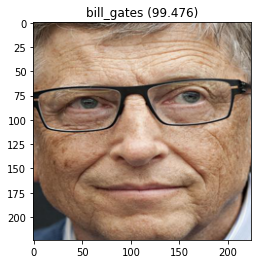

[[0.99540406 0.00239699 0.00219896]]
Predicted: bill_gates (99.540)
Expected: bill_gates
1


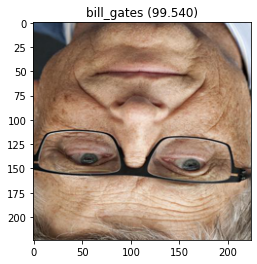

[[0.98225493 0.010194   0.00755107]]
Predicted: bill_gates (98.225)
Expected: bill_gates
2


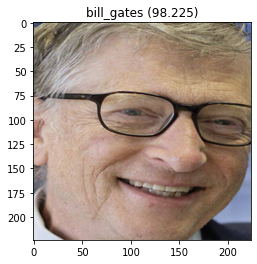

[[0.98229826 0.00509742 0.01260433]]
Predicted: bill_gates (98.230)
Expected: bill_gates
3


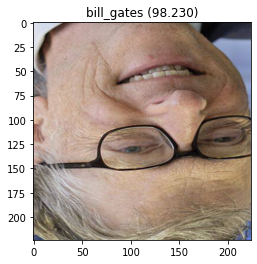

[[9.97880796e-01 9.15822484e-04 1.20338137e-03]]
Predicted: bill_gates (99.788)
Expected: bill_gates
4


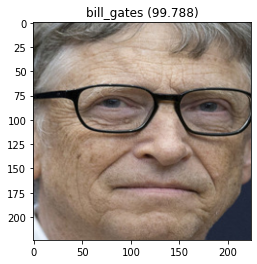

[[0.98729294 0.00533422 0.00737285]]
Predicted: bill_gates (98.729)
Expected: bill_gates
5


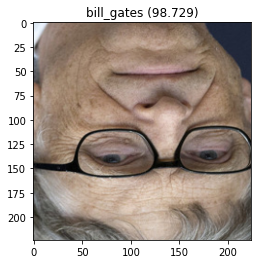

[[0.99652705 0.00123196 0.00224099]]
Predicted: bill_gates (99.653)
Expected: bill_gates
6


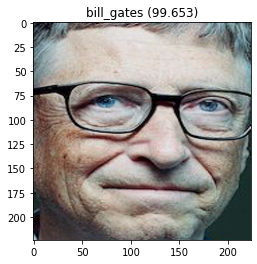

[[0.98443803 0.00584702 0.00971496]]
Predicted: bill_gates (98.444)
Expected: bill_gates
7


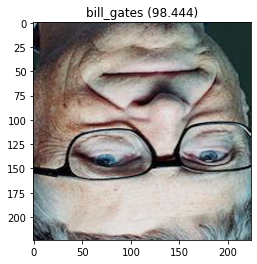

[[0.99112793 0.00273451 0.00613755]]
Predicted: bill_gates (99.113)
Expected: bill_gates
8


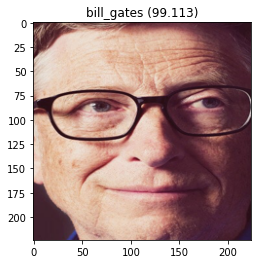

[[0.955811   0.01327169 0.03091731]]
Predicted: bill_gates (95.581)
Expected: bill_gates
9


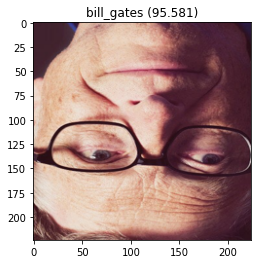

[[0.00193059 0.02376728 0.97430213]]
Predicted: jeff_bezos (97.430)
Expected: jeff_bezos
10


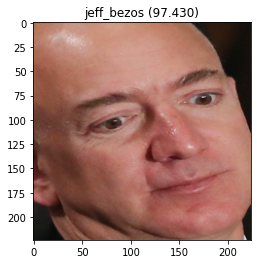

[[0.01482966 0.59527076 0.38989958]]
Predicted: elon_musk (59.527)
Expected: jeff_bezos
11


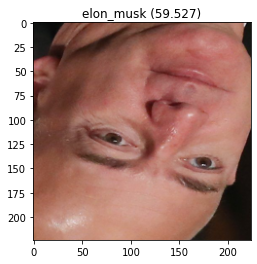

[[0.00600013 0.01815162 0.97584826]]
Predicted: jeff_bezos (97.585)
Expected: jeff_bezos
12


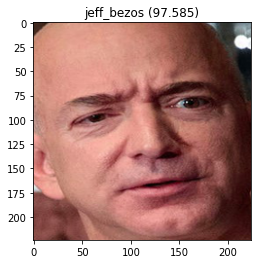

[[0.08352513 0.09904983 0.81742504]]
Predicted: jeff_bezos (81.743)
Expected: jeff_bezos
13


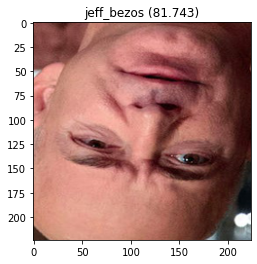

[[0.00149031 0.0011757  0.99733399]]
Predicted: jeff_bezos (99.733)
Expected: jeff_bezos
14


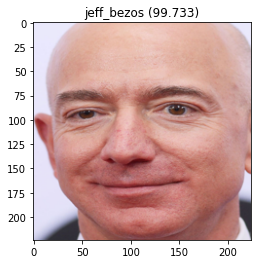

[[0.00753341 0.00349936 0.98896723]]
Predicted: jeff_bezos (98.897)
Expected: jeff_bezos
15


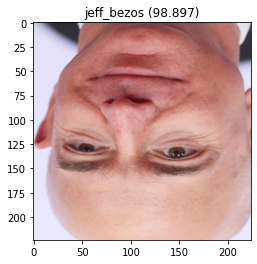

[[0.0144513  0.05241406 0.93313464]]
Predicted: jeff_bezos (93.313)
Expected: jeff_bezos
16


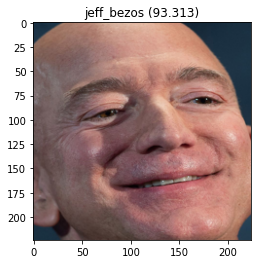

[[0.08110237 0.14837701 0.77052062]]
Predicted: jeff_bezos (77.052)
Expected: jeff_bezos
17


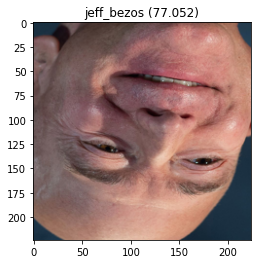

[[0.00410207 0.00664164 0.98925629]]
Predicted: jeff_bezos (98.926)
Expected: jeff_bezos
18


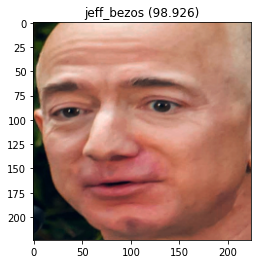

[[0.08126075 0.13727466 0.78146459]]
Predicted: jeff_bezos (78.146)
Expected: jeff_bezos
19


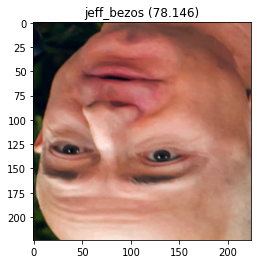

[[0.00755969 0.98447841 0.0079619 ]]
Predicted: elon_musk (98.448)
Expected: elon_musk
20


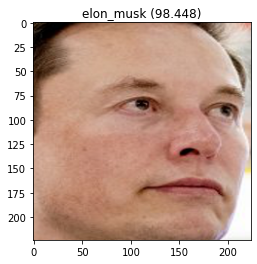

[[0.00191334 0.98330848 0.01477818]]
Predicted: elon_musk (98.331)
Expected: elon_musk
21


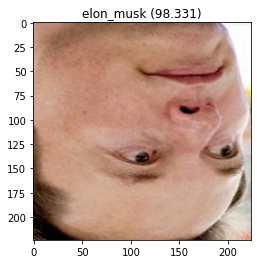

[[0.00697303 0.98107621 0.01195077]]
Predicted: elon_musk (98.108)
Expected: elon_musk
22


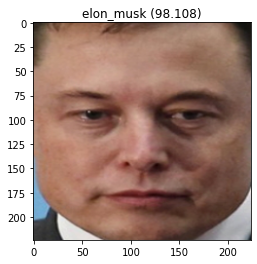

[[0.02227921 0.93125522 0.04646557]]
Predicted: elon_musk (93.126)
Expected: elon_musk
23


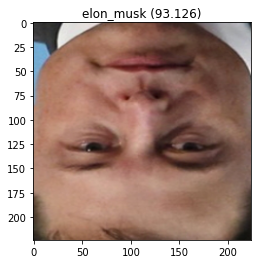

[[0.00318467 0.98822595 0.00858939]]
Predicted: elon_musk (98.823)
Expected: elon_musk
24


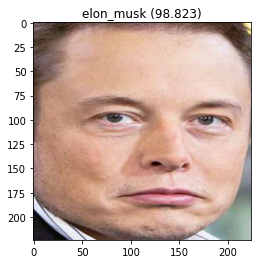

[[0.02233882 0.81458088 0.16308031]]
Predicted: elon_musk (81.458)
Expected: elon_musk
25


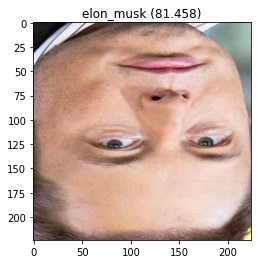

[[0.01390042 0.95162409 0.03447549]]
Predicted: elon_musk (95.162)
Expected: elon_musk
26


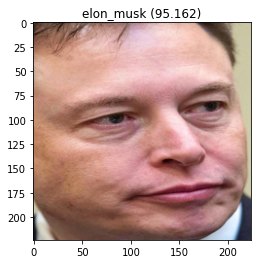

[[0.11378283 0.50298    0.38323717]]
Predicted: jeff_bezos (38.324)
Expected: elon_musk
27


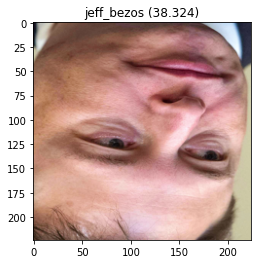

[[0.00224324 0.99496778 0.00278898]]
Predicted: elon_musk (99.497)
Expected: elon_musk
28


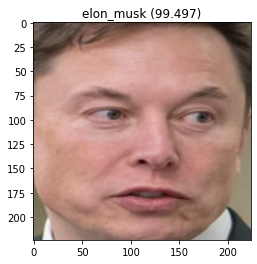

[[0.00916035 0.96493646 0.02590319]]
Predicted: elon_musk (96.494)
Expected: elon_musk
29


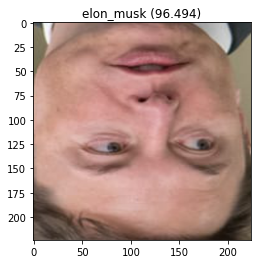

Test accuracy:  0.9333333333333333
Test f1:  0.9333333333333333


In [14]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib import pyplot
from scipy.spatial.distance import cosine
# load faces
data = load('/content/tech-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('/content/tech-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True, random_state = True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
all = []
all_idx = 0
for i in range(testX.shape[0]):
  selection = i
  random_face_pixels = testX_faces[selection]
  random_face_emb = testX[selection]
  random_face_class = testy[selection]
  random_face_name = out_encoder.inverse_transform([random_face_class])
  # prediction for the face
  samples = expand_dims(random_face_emb, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
  print(yhat_prob)
  if random_face_name[0] == 'bill_gates':
    all.append(yhat_prob[0][0])
  elif random_face_name[0] == 'elon_musk':
    all.append(yhat_prob[0][1])
  elif random_face_name[0] == 'jeff_bezos':
    all.append(yhat_prob[0][2])
  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
  print('Expected: %s' % random_face_name[0])
  print(all_idx)
  all_idx+=1
  # plot for fun
  pyplot.imshow(random_face_pixels)
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  pyplot.title(title)
  pyplot.show()
yhat = model.predict(testX)
print('Test accuracy: ', accuracy_score(testy,yhat))
print('Test f1: ', f1_score(testy,yhat, average='weighted'))

Plot results for each model and print t-test results:

In [19]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import statistics 
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ydiff = []

for i in range(0,29,2):
  ydiff.append(all[i]-all[i+1]) 
#perfom one sample t test and print results 
#n = len(ydiff)
#print(n)
print(ydiff)
t, p = stats.ttest_1samp(ydiff,0.0)
print(t, p)
#print sample mean
print(statistics.mean(ydiff))
fig = go.Figure(data=[
    go.Bar(x=x, y=ydiff),
])
fig.update_layout(barmode='group')
fig.show()

[-0.0006472425771134604, -4.332748142998888e-05, 0.010587859447902193, 0.012089023648734099, 0.035316938338887605, 0.5844025483852346, 0.1584232180835088, 0.008366759829380843, 0.16261401359792282, 0.207791700838582, 0.0011699358854885267, 0.04982099037343768, 0.17364506992527273, 0.44864409191951005, 0.0300313207560291]
2.752425279544 0.01557065375401771
0.1254808600647565


Another way to do the classification phase:

In [0]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
face_dict = {}
face_dict['/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff.jpg'] = [399, 933, 47, 783]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill2.jpg'] = [403, 723, 146, 533]
face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon.jpg']=[717, 1668, 486, 1816]
face_dict['/content/facial_recognition/validation/elon_musk/upsidedown_elon.jpg']=[717, 1668, 486, 1816]
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	if len(results) == 0:
		x1=face_dict[filename][0]
		x2=face_dict[filename][1]
		y1=face_dict[filename][2]
		y2=face_dict[filename][3]
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else:
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
  # extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model 
  # keeps all layers except last one that makes prediction 
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat
 
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.9):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
# determine if a candidate face is a match for a known face
def is_thatcher(known_embedding, candidate_embedding, candidate_embedding1, candidate_embedding2):
	# calculate distance between embeddings
  scoreUP = cosine(known_embedding, candidate_embedding)
  scoreDOWN = cosine(candidate_embedding1, candidate_embedding2)
  if scoreUP > scoreDOWN:
    print('>face Induces Thatcher (%.3f > %.3f)' % (scoreUP, scoreDOWN))
  else:
    print('>face Does NOT Induce Thatcher (%.3f UP < %.3f DOWN)' % (scoreUP, scoreDOWN))
#filenames1 = ['/content/facial_recognition/validation/elon_musk/e5.jpg', '/content/facial_recognition/validation/elon_musk/flipped_feat.jpg', '/content/facial_recognition/validation/elon_musk/upsidedown_elon.jpg', '/content/facial_recognition/validation/elon_musk/thatcher_elon.jpg']
#filenames2 = ['/content/facial_recognition/validation/elon_musk/e6.jpeg','/content/facial_recognition/validation/elon_musk/flipped_feat2.jpeg', '/content/facial_recognition/validation/elon_musk/upsidedown_elon2.jpeg','/content/facial_recognition/validation/elon_musk/thatcher_elon1.jpeg']
#filenames1 = ['/content/facial_recognition/validation/jeff_bezos/135ace03cda6428a60c025bea3089db987-16-jeff-bezos.2x.rhorizontal.w710.jpg','/content/facial_recognition/validation/jeff_bezos/flipped_feat2.jpg', '/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff.jpg', '/content/facial_recognition/validation/jeff_bezos/thatcher2_jeff.jpg']
#filenames2 = ['/content/facial_recognition/validation/jeff_bezos/jeff-bezos.jpg','/content/facial_recognition/validation/jeff_bezos/flipped_feat.jpg','/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff2.jpg','/content/facial_recognition/validation/jeff_bezos/thatcher_jeff-bezos.jpg' ]
filenames1 = ['/content/facial_recognition/validation/bill_gates/ap191257847753312437800429_t1070_hba82ab2fd84bf4215f48777f7a1936f2feee486f.jpg','/content/facial_recognition/validation/bill_gates/flipped_feat.jpg','/content/facial_recognition/validation/bill_gates/upsidedown_bill3.jpg', '/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpg' ]
#filenames2 = ['/content/facial_recognition/validation/bill_gates/Flickr_BillGates.jpg','/content/facial_recognition/validation/bill_gates/flipped_feat2.jpg','/content/facial_recognition/validation/bill_gates/upsidedown_bill2.jpg','/content/facial_recognition/validation/bill_gates/thatcher_bill2.jpg' ]
filenames2 = ['/content/facial_recognition/validation/bill_gates/TELEMMGLPICT000140063746_trans++tt-PMhmmlxqdgRPvuJG6C_36TkPi4jZ3eU8IBZq6ki0.jpeg','/content/facial_recognition/validation/bill_gates/flipped_feat3.jpeg','/content/facial_recognition/validation/bill_gates/upsidedown_bill.jpeg','/content/facial_recognition/validation/bill_gates/thatcher_bill.jpeg' ]
# get embeddings file filenames
embeddings = get_embeddings(filenames1)
normal_img = embeddings[0]
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
is_match(embeddings[0], embeddings[3])
print('Thatcher Tests on Bill with no glasses')
is_thatcher(embeddings[0], embeddings[1], embeddings[2], embeddings[3])
embeddings2 = get_embeddings(filenames2)
# define normal image
normal_img2 = embeddings2[0]
is_match(embeddings2[0], embeddings2[1])
is_match(embeddings2[0], embeddings2[2])
is_match(embeddings2[0], embeddings2[3])
print('Thatcher Tests on Grey background Bill')
is_thatcher(embeddings2[0], embeddings2[1], embeddings2[2], embeddings2[3])

>face is a Match (0.160 <= 0.900)
>face is a Match (0.854 <= 0.900)
>face is a Match (0.793 <= 0.900)
Thatcher Tests on Bill with no glasses
>face Does NOT Induce Thatcher (0.160 UP < 0.192 DOWN)
>face is a Match (0.056 <= 0.900)
>face is a Match (0.724 <= 0.900)
>face is a Match (0.655 <= 0.900)
Thatcher Tests on Grey background Bill
>face Does NOT Induce Thatcher (0.056 UP < 0.115 DOWN)
